# Making various plots

- MaxFuse annotations
    - Focus on UCD2, MCD1
    - Particular attention towards FSC1, FSC2, PRCd 
- etc

In [1]:
import tifffile as tff
import re
# from cv2 import imwrite
import pandas as pd
import numpy as np
import pickle as pk
import matplotlib.pyplot as plt
import matplotlib as mplb
import matplotlib.cm as cm
from tqdm import tqdm
from imantics import Polygons, Mask
import geojson as gjson
import argparse
from scipy import signal, ndimage
import scipy as sci
import random
import os
import anndata as ad
from PIL import Image

from scipy.spatial import ConvexHull, convex_hull_plot_2d
from skimage.draw import polygon2mask
import shapely as shp
import geopandas as gpd

import seaborn as sns
import matplotlib as mpl

ERROR 1: PROJ: proj_create_from_database: Open of /home/smithd30/miniconda3/envs/imageAnalysis/share/proj failed


In [2]:
codex = ad.read_h5ad("/mnt/isilon/cscb/Projects/codex/pillaiv/SCTC-VP-15/code/CD_analysis/aSMA_CD21_analysis/all_regions_dat.h5ad")
codex

AnnData object with n_obs × n_vars = 3895114 × 38
    obs: 'Unnamed: 0', 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'Reg', 'Tile.Row', 'Tile.Col', 'Tile.Z', 'In.Tile.Y', 'In.Tile.X', 'Absolute.Y', 'Absolute.X', 'Cell.Size', 'n_genes_by_counts', 'total_counts', 'nCount_raw', 'nFeature_raw', 'cell_type_pred_knn', 'cell_type_pred_knn_prob', 'motif', 'index_info', 'new_pheno', 'region'
    uns: 'lda_10', 'lda_10_probability', 'lda_12', 'lda_12_probability', 'lda_15', 'lda_15_probability', 'lda_8', 'lda_8_probability', 'spatial_lda', 'spatial_lda_probability'

In [3]:
codex.obs['case'] = codex.obs['region'].apply(lambda x: x.split("_")[0])
codex.obs['disease'] = codex.obs['case'].apply(lambda x: x[:-1])

In [4]:
codex.obs['fuse_pheno'] = codex.obs.new_pheno.astype(str)
for full_r in tqdm(codex.obs.region.unique()):
    # adata = codex[codex.obs.region == full_r,:].copy()
    fuse_dat = ad.read_h5ad("../maxfuse/maxfuse_out/"+full_r+"fuse_anno.h5ad")
    fuse_dat.obs_names = ["_".join([bc,full_r]) for bc in fuse_dat.obs_names.tolist()]
    # adata = adata[fuse_dat.obs_names,:]
    codex.obs.loc[fuse_dat.obs_names, "fuse_pheno"] = fuse_dat.obs.fuse_pheno

100%|██████████| 24/24 [00:24<00:00,  1.00s/it]


In [5]:
codex.obs.fuse_pheno.value_counts()

fuse_pheno
B_Cell                                 993653
CD4_T_Cell                             855696
Macrophage                             419503
Plasma_Cell                            404130
CD8_T_Cell                             389830
pDC                                    112332
Fibroblastic stromal cell, type 1      102669
Endothelial                             98715
Fibroblastic stromal cell, type 2       70757
lymphatic endothelial cell              53860
Stromal                                 49350
cDC2                                    44875
blood endothelial cell                  42522
cDC1                                    35124
Tfh                                     30480
FDC                                     30398
T_cell                                  30115
ACTA2+ perivascular reticular cells     26384
Memory or effector T cells              19672
Cytotoxic_T_Cell                        18559
myeloid                                 14504
immune                 

In [5]:
codex.obs.loc[codex.obs.fuse_pheno=="Endothelial", "fuse_pheno"] = "blood endothelial cell"

In [6]:
# exporting obs for stats in R

codex.obs.to_csv("CD_metadata_withMaxfuse.csv")

## Need to clean up some MaxFuse labels

"Lymphatics" -> "lymphatic endothelial cell"

...or maybe not...doesn't seem that redundant

In [11]:
# codex.obs.fuse_pheno.value_counts()
codex.obs.region.unique()

['MCD1_reg1', 'MCD3_reg2', 'MCD1_reg3', 'HVCD2_reg1', 'R1_reg3', ..., 'MCD1_reg4', 'HVCD1_reg2', 'MCD1_reg2', 'HVCD2_reg4', 'R1_reg1']
Length: 24
Categories (24, object): ['MCD1_reg1', 'MCD3_reg2', 'MCD1_reg3', 'HVCD2_reg1', ..., 'HVCD1_reg2', 'MCD1_reg2', 'HVCD2_reg4', 'R1_reg1']

In [6]:
len(codex.obs.fuse_pheno.unique())

28

# The Napari part

In [ ]:
import numpy as np
import anndata as ad
import pandas as pd
import matplotlib as mpl

dat = pd.read_csv("...")

ct_names = dat.fuse_pheno.unique()
cmap = mpl.colormaps['tab20']
col_names = list(map(mpl.colors.to_hex, cmap.colors))
ct_col_dict = {ct_names[i]:cmap.colors[i % 20] for i in range(len(ct_names))}

for ct in dat.fuse_pheno.unique():
    points = dat.loc[dat.fuse_pheno == ct, ['Absolute.Y', 'Absolute.X']]
    c = ct_col_dict[ct]
    viewer.add_points(points, name=ct, size=30, face_color=np.tile(c,points.shape[0]).reshape([-1, 3]))

# UCD2

I actually already have a demo image for this: "../mantle_analysis/demo_hvcd2_reg2.ome.tiff"

In [6]:
img = tff.TiffFile("/mnt/isilon/cscb/Projects/codex/pillaiv/SCTC-VP-15/code/forQuPath/Data/HVCD2_reg2/input_codex.qptiff")
img = img.asarray()
# img_out = img[[0,28,40,33],...] # DAPI, CD20, asma, CD45
# CD20, CD3, CD21, ... CD31/34 (41,42)
# img_out = img[[28,39,38],...] 
img_out = img[[40,38],...] # asma, CD21, CD31/34
endo_layer = np.apply_over_axes(np.sum, img[[41,42],...], 0)/2
img_out = np.concatenate((img_out, endo_layer))

In [12]:
img_out.shape

(4, 7518, 10024)

In [7]:
xml = f"""<?xml version="1.0" encoding="UTF-8"?>
		<OME xmlns="http://www.openmicroscopy.org/Schemas/OME/2016-06"
			xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance"
			xsi:schemaLocation="http://www.openmicroscopy.org/Schemas/OME/2016-06 http://www.openmicroscopy.org/Schemas/OME/2016-06/ome.xsd">
			<Image ID="Image:0" Name="HVCD2_reg3">
				<Pixels BigEndian="false"
						DimensionOrder="XYCZT"
						ID="Pixels:0"
						Interleaved="false"
						SizeC={img_out.shape[0]}
						SizeT=1
						SizeX={img_out.shape[2]}
						SizeY={img_out.shape[1]}
						SizeZ=1
						PhysicalSizeX=1.0
						PhysicalSizeY=1.0
						Type="float">
                </Pixels>
			</Image>
		</OME>"""
		
tff.imwrite(
    "demo_HVCD2_reg2_v2.ome.tiff",
    data=img_out,
    photometric='minisblack',
    description=xml
)

In [17]:
out = codex.obs.loc[codex.obs.region=="HVCD2_reg2",:]

In [ ]:
out.loc[:,['fuse_pheno', 'Absolute.Y', 'Absolute.X']].to_csv("HVCD2_reg2_annotations.csv")

# MCD1

In [8]:
img = tff.TiffFile("/mnt/isilon/cscb/Projects/codex/pillaiv/SCTC-VP-15/code/forQuPath/Data/MCD1_reg4/input_codex.qptiff")
img = img.asarray()
# img_out = img[[0,28,40,33],...] # DAPI, CD20, asma, CD45
# CD20, CD3, CD21, ... CD31/34 (41,42)
# img_out = img[[28,39,38],...] 
img_out = img[[40,38],...] # asma, CD21, CD31/34
endo_layer = np.apply_over_axes(np.sum, img[[41,42],...], 0)/2
img_out = np.concatenate((img_out, endo_layer))

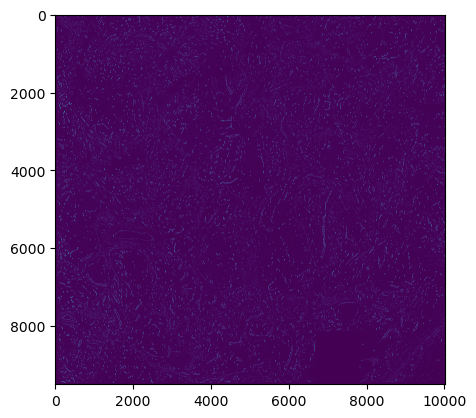

In [11]:
# plt.imshow(img_out[2,...])
plt.imshow(endo_layer[0,...])

In [9]:
xml = f"""<?xml version="1.0" encoding="UTF-8"?>
		<OME xmlns="http://www.openmicroscopy.org/Schemas/OME/2016-06"
			xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance"
			xsi:schemaLocation="http://www.openmicroscopy.org/Schemas/OME/2016-06 http://www.openmicroscopy.org/Schemas/OME/2016-06/ome.xsd">
			<Image ID="Image:0" Name="HVCD2_reg3">
				<Pixels BigEndian="false"
						DimensionOrder="XYCZT"
						ID="Pixels:0"
						Interleaved="false"
						SizeC={img_out.shape[0]}
						SizeT=1
						SizeX={img_out.shape[2]}
						SizeY={img_out.shape[1]}
						SizeZ=1
						PhysicalSizeX=1.0
						PhysicalSizeY=1.0
						Type="float">
                </Pixels>
			</Image>
		</OME>"""
		
tff.imwrite(
    "demo_MCD1_reg4_v2.ome.tiff",
    data=img_out,
    photometric='minisblack',
    description=xml
)

In [16]:
out = codex.obs.loc[codex.obs.region=="MCD1_reg4",:]
out.loc[:,['fuse_pheno', 'Absolute.Y', 'Absolute.X']].to_csv("MCD1_reg4_annotations.csv")

# R1

In [10]:
img = tff.TiffFile("/mnt/isilon/cscb/Projects/codex/pillaiv/SCTC-VP-15/code/forQuPath/Data/R1_reg1/input_codex.qptiff")
img = img.asarray()
# img_out = img[[0,28,40,33],...] # DAPI, CD20, asma, CD45
# CD20, CD3, CD21, ... CD31/34 (41,42)
# img_out = img[[28,39,38],...] 
img_out = img[[39,38],...] # CD3, CD21, CD31/34
endo_layer = np.apply_over_axes(np.sum, img[[41,42],...], 0)/2
img_out = np.concatenate((img_out, endo_layer))

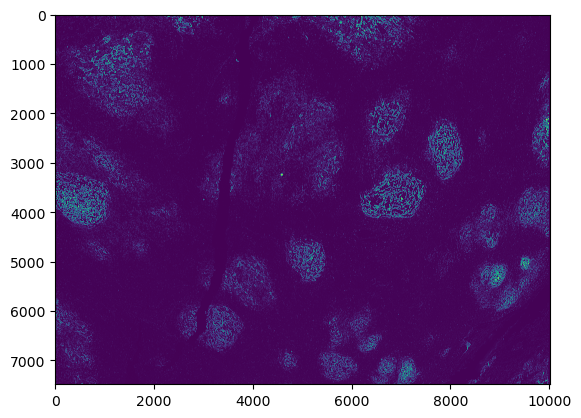

In [13]:
plt.imshow(img_out[2,...])

In [11]:
xml = f"""<?xml version="1.0" encoding="UTF-8"?>
		<OME xmlns="http://www.openmicroscopy.org/Schemas/OME/2016-06"
			xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance"
			xsi:schemaLocation="http://www.openmicroscopy.org/Schemas/OME/2016-06 http://www.openmicroscopy.org/Schemas/OME/2016-06/ome.xsd">
			<Image ID="Image:0" Name="HVCD2_reg3">
				<Pixels BigEndian="false"
						DimensionOrder="XYCZT"
						ID="Pixels:0"
						Interleaved="false"
						SizeC={img_out.shape[0]}
						SizeT=1
						SizeX={img_out.shape[2]}
						SizeY={img_out.shape[1]}
						SizeZ=1
						PhysicalSizeX=1.0
						PhysicalSizeY=1.0
						Type="float">
                </Pixels>
			</Image>
		</OME>"""
		
tff.imwrite(
    "demo_R1_reg1_v2.ome.tiff",
    data=img_out,
    photometric='minisblack',
    description=xml
)

In [17]:
out = codex.obs.loc[codex.obs.region=="R1_reg3",:]
out.loc[:,['fuse_pheno', 'Absolute.Y', 'Absolute.X']].to_csv("R1_reg3_annotations.csv")